<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/5_Forecasting%20%7C%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install wandb -qqq
import wandb
wandb.login()

True

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/final.csv', parse_dates=['dates'],  index_col='dates',infer_datetime_format=True)
df.drop(['Unnamed: 0', 'Purity'], axis=1, inplace=True)

In [ ]:
import tensorflow as tf

from matplotlib.pyplot import figure
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Normalization
values = df[['% Silica Concentrate']].values

# Normalization
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(values)

In [ ]:
def create_data(series, prev_instances = 4):
 
    X_train_1 = pd.DataFrame(series).astype('float64')
    X_train_temp = X_train_1.shift(1)
    y_label = X_train_1.shift(-1)
    
    data = pd.concat([X_train_temp, X_train_1, y_label], axis=1)
    
    for r in range(prev_instances-2):
        X_train_temp = X_train_temp.shift(1)
        data = pd.concat([X_train_temp, data], axis=1)
    data.dropna(inplace = True)
    data.reset_index(drop = True, inplace = True)
    # print(data.head(10))
    X = data.iloc[:, 0:-1].values 
    y = data.iloc[:,-1].values 
    
    print('This series takes {} previous instances'.format(prev_instances))
    
    data.columns = [*data.columns[:-1], 'y']
    
    return data, X, y

In [ ]:
WINDOW_SIZE = 5

time_series = scaled_data;
data, X, y = create_data(time_series, prev_instances = WINDOW_SIZE)

This series takes 5 previous instances


In [ ]:
# 70% 15% 15%

X_train, y_train = X[:2664], y[:2664]
X_test, y_test = X[2664:3235], y[2664:3235]
X_val, y_val = X[3235:], y[3235:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((2664, 5), (2664,), (571, 5), (571,), (565, 5), (565,))

You always have to give a three-dimensional array as an input to your LSTM network. Where the first dimension represents the batch size, the second dimension represents the number of time-steps you are feeding a sequence. And the third dimension represents the number of units in one input sequence. For example, input shape looks like (batch_size, time_steps, seq_len)

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], WINDOW_SIZE,1))
X_test = X_test.reshape((X_test.shape[0], WINDOW_SIZE, 1))
X_val = X_val.reshape((X_val.shape[0], WINDOW_SIZE, 1))
    
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((2664, 5, 1), (2664,), (571, 5, 1), (571,), (565, 5, 1), (565,))

In [ ]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  
    mae = np.mean(np.abs(forecast - actual))    
    rmse = np.mean((forecast - actual)**2)**.5  

    return mape, mae, rmse

In [ ]:
sweep_lstm_config = {
    "method": "random", # try grid or random
    "metric": {
      "name": "MAPE",
      "goal": "minimize"   
    },
    "parameters": {
          "learning_rate": {
            "values": [0.001, 0.025, 0.01]
        },
        "epochs": {
            "values": [100, 200, 300]
        },
        
        "batch_size": {
            "values": [32, 64, 128]
        }
    }
}

sweep_id = wandb.sweep(sweep_lstm_config, project="Stacked_lstm_shot_1")

Create sweep with ID: mybp5ysv
Sweep URL: https://wandb.ai/malekkamoua/Stacked_lstm_shot_1/sweeps/mybp5ysv


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, InputLayer

from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError, MeanAbsolutePercentageError
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# Define early_stopping_monitor
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=2)

from wandb.keras import WandbCallback

def train():
  config_defaults = {
    "learning_rate": 0.001,
    "epochs": 100,
    "batch_size": 32,
    'shuffle': False
  }

  wandb.init(config=config_defaults)  # defaults are over-ridden during the sweep
  config = wandb.config

  #define the model
  model = Sequential()
  model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1] ,1)))
  model.add(LSTM(50, activation='relu'))
  model.add(Dense(1))

  cp = ModelCheckpoint('model/', save_best_only=True)

  #define the model
  model=Sequential()
  model.add(LSTM(200,return_sequences=True,input_shape=(X_train.shape[1],1)))
  model.add(Dense(100, activation='relu'))
  model.add(LSTM(100,return_sequences=True))
  model.add(Dense(50, activation='relu'))
  model.add(LSTM(50))
  model.add(Dense(1))

  model.compile( loss = MeanSquaredError(), 
                    optimizer = Adam(learning_rate= wandb.config['learning_rate']), 
                    metrics=['mae',
                          MeanSquaredError(),
                          RootMeanSquaredError(),
                          MeanAbsolutePercentageError()])

  history = model.fit(X_train, y_train, 
                      epochs = wandb.config['epochs'] , 
                      batch_size = wandb.config['batch_size'],
                      shuffle = wandb.config['shuffle'],
                      validation_data=(X_test, y_test),
                      callbacks= [early_stopping_monitor, 
                                  WandbCallback()])  
  
  y_pred_test_LSTM = model.predict(np.asarray(X_test).astype('float32'))
  Inverse_y_test = y_test.reshape(-1,1)
  Inverse_y_test = scaler.inverse_transform(Inverse_y_test)
  Inverse_y_pred_test_LSTM = y_pred_test_LSTM.reshape(-1,1)
  Inverse_y_pred_test_LSTM = scaler.inverse_transform(Inverse_y_pred_test_LSTM)

  mape, mae, rmse = forecast_accuracy(Inverse_y_pred_test_LSTM, Inverse_y_test)

  wandb.log({"MAPE": mape})

  wandb.finish()

In [ ]:
wandb.agent(sweep_id, train, count=40)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, InputLayer

from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError, MeanAbsolutePercentageError
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# Define early_stopping_monitor
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=2)

cp = ModelCheckpoint('model/', save_best_only=True)

#define the model
model=Sequential()
model.add(LSTM(200,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(Dense(100, activation='relu'))
model.add(LSTM(100,return_sequences=True))
model.add(Dense(50, activation='relu'))
model.add(LSTM(50))
model.add(Dense(1))
model.compile( loss = MeanSquaredError(), 
                  optimizer = Adam(learning_rate= 0.001), 
                  metrics=['mae',
                        MeanSquaredError(),
                        RootMeanSquaredError(),
                        MeanAbsolutePercentageError()])

history_LSTM = model.fit(X_train, y_train, 
                              epochs = 100 , 
                              batch_size = 64,
                              shuffle =False,
                              validation_data=(X_test, y_test),
                              callbacks= [cp,
                                          early_stopping_monitor])    
model.summary()

y_pred_test_LSTM = model.predict(np.asarray(X_test).astype('float32'))
Inverse_y_test = y_test.reshape(-1,1)
Inverse_y_test = scaler.inverse_transform(Inverse_y_test)
Inverse_y_pred_test_LSTM = y_pred_test_LSTM.reshape(-1,1)
Inverse_y_pred_test_LSTM = scaler.inverse_transform(Inverse_y_pred_test_LSTM)

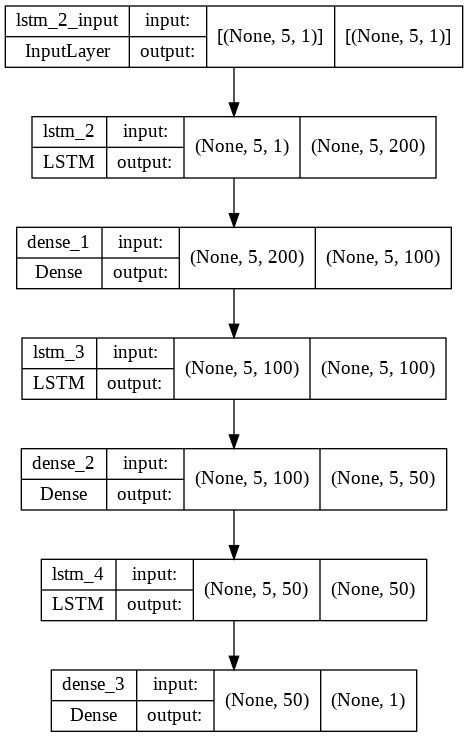

In [ ]:
from keras.models import load_model
from keras.utils.vis_utils import plot_model

best_model = load_model('/content/gdrive/MyDrive/Datascience/PFE/lstm-best.h5', compile=False)
plot_model(best_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
y_pred_train_LSTM = best_model.predict(np.asarray(X_train).astype('float32'))
Inverse_y_train = y_train.reshape(-1,1)
Inverse_y_train = scaler.inverse_transform(Inverse_y_train)
Inverse_y_pred_train_LSTM = y_pred_train_LSTM.reshape(-1,1)
Inverse_y_pred_train_LSTM = scaler.inverse_transform(Inverse_y_pred_train_LSTM)

y_pred_test_LSTM = best_model.predict(np.asarray(X_test).astype('float32'))
Inverse_y_test = y_test.reshape(-1,1)
Inverse_y_test = scaler.inverse_transform(Inverse_y_test)
Inverse_y_pred_test_LSTM = y_pred_test_LSTM.reshape(-1,1)
Inverse_y_pred_test_LSTM = scaler.inverse_transform(Inverse_y_pred_test_LSTM)

y_pred_val_LSTM = best_model.predict(np.asarray(X_val).astype('float32'))
Inverse_y_val = y_val.reshape(-1,1)
Inverse_y_val = scaler.inverse_transform(Inverse_y_val)
Inverse_y_pred_val_LSTM = y_pred_val_LSTM.reshape(-1,1)
Inverse_y_pred_val_LSTM = scaler.inverse_transform(Inverse_y_pred_val_LSTM)

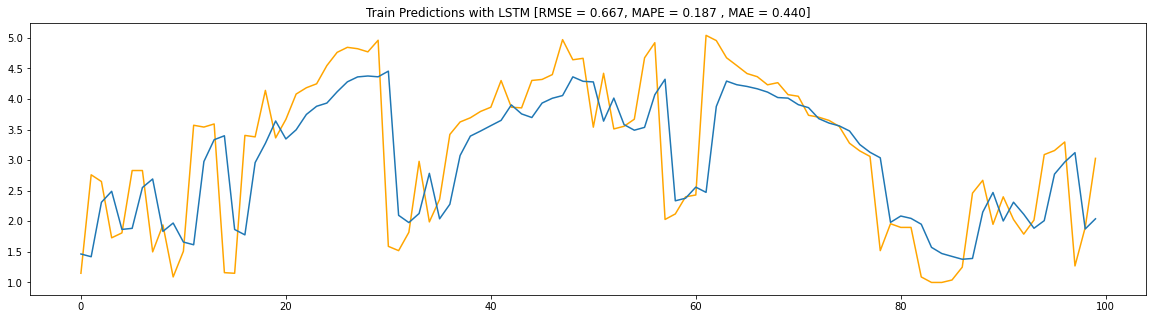

In [51]:
mape, mae, rmse = forecast_accuracy(Inverse_y_pred_train_LSTM, Inverse_y_train)

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(Inverse_y_train[0:100], color='orange')
plt.plot(Inverse_y_pred_train_LSTM[0:100])
plt.title("Train Predictions with LSTM [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
plt.show()

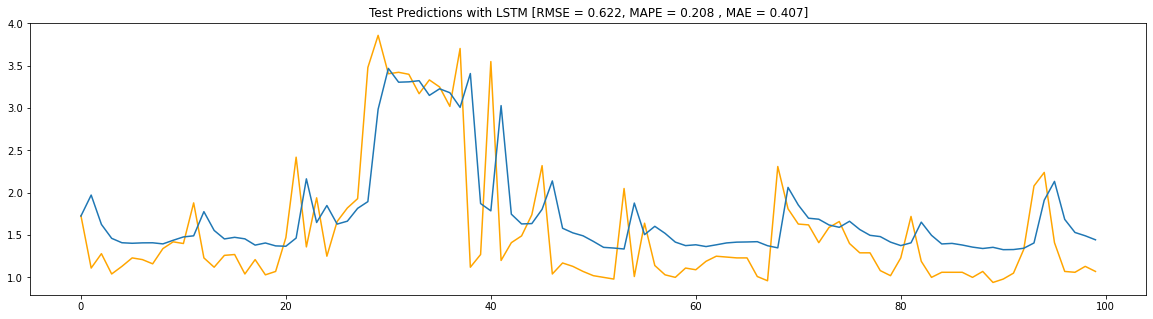

In [ ]:
mape, mae, rmse = forecast_accuracy(Inverse_y_pred_test_LSTM, Inverse_y_test)

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(Inverse_y_test[0:100], color='orange')
plt.plot(Inverse_y_pred_test_LSTM[0:100])
plt.title("Test Predictions with LSTM [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
plt.show()

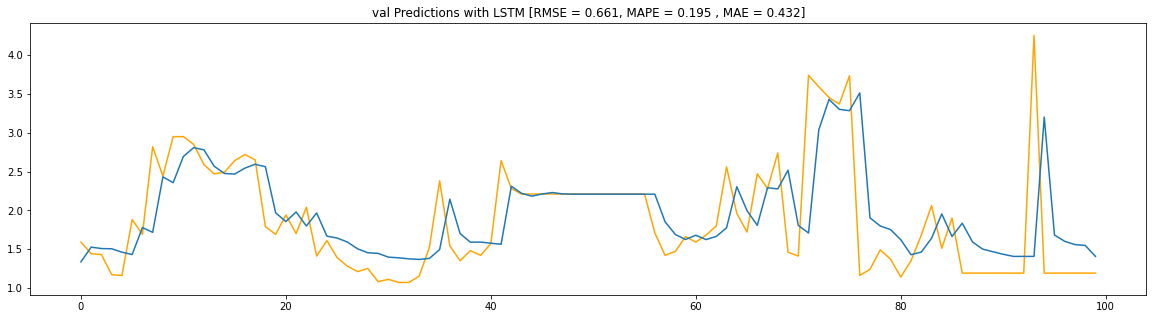

In [ ]:
mape, mae, rmse = forecast_accuracy(Inverse_y_pred_val_LSTM, Inverse_y_val)

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(Inverse_y_val[0:100], color='orange')
plt.plot(Inverse_y_pred_val_LSTM[0:100])
plt.title("val Predictions with LSTM [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
plt.show()

## View report ✅
https://wandb.ai/malekkamoua/Stacked_lstm_shot_1/reports/Best-lstm-model--VmlldzoxODkwMjA0?accessToken=vh2192nzys8i3a28xbl14c3sba2lfvzxco55ukhf3nrr949eyc2t2gjf7d49m1en